In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SelfAttention(nn.Module):
    def __init__(self, in_channels=64):
        super().__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key   = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.shape

        # Q, K, V projections
        q = self.query(x).view(B, -1, H * W).permute(0, 2, 1)  # [B, HW, C_new]
        k = self.key(x).view(B, -1, H * W)                     # [B, C_new, HW]
        v = self.value(x).view(B, -1, H * W)                   # [B, C,  HW]

        # Attention map
        attn = torch.bmm(q, k)                                 # [B, HW, HW]
        attn = F.softmax(attn, dim=-1)

        # Apply attention to value
        out = torch.bmm(v, attn.permute(0, 2, 1))              # [B, C, HW]
        out = out.view(B, C, H, W)

        return self.gamma * out + x

In [2]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, embed_dim=5, output_channels=7, feature_map=64, picture_size=14):
        super().__init__()
        self.picture_size = 14

        self.feature_map = feature_map

        # Embed feature vector u [B, 5] -> [B, 14 * 14]
        self.embed = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(),
            nn.Linear(256, self.picture_size * self.picture_size)
        )

        # Latent vector z [B, noise_dim] -> feature map [B, feature_map * (pic_size // 2)^2]
        self.fc = nn.Linear(noise_dim, feature_map * (self.picture_size // 2) * (self.picture_size // 2))

        # Upsample to 7x7 -> 14x14
        self.upsample = nn.Sequential(
            nn.BatchNorm2d(feature_map),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_map, feature_map, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_map),
            nn.ReLU()
        )

        self.attn = SelfAttention(feature_map)

        # Output: [B, output_channels, pic_size, pic_size]
        self.out = nn.Conv2d(feature_map + 1, output_channels, kernel_size=1)

    # z: [B, noise_dim]
    # u: [B, embed_dim]
    def forward(self, z, u):
       # x: [B, feature_map, pic_size // 2, pic_size // 2]
        x = self.fc(z).view(-1, self.feature_map, self.picture_size // 2, self.picture_size // 2)
        # x: [B, feature_map, pic_size, pic_size]
        x = self.upsample(x)
        # x: [B, feature_map, pic_size, pic_size]
        x = self.attn(x)


        # u_embed: [B, 1, pic_size, pic_size]
        u_embed = self.embed(u).view(-1, 1, self.picture_size, self.picture_size)

        # x: [B, feature_map + 1, pic_size, pic_size]
        x = torch.cat([x, u_embed], dim=1)

        # out: [B, output_channels, pic_size, pic_size]
        return self.out(x)

In [3]:
class Discriminator(nn.Module):
    def __init__(self, input_channels=10, embed_dim=5, feature_map_size=64, picture_size=14):
        super().__init__()
        self.picture_size = picture_size
        self.feature_map = feature_map_size

        # Embed feature vector u -> [B, 1, H, W]
        self.embed = nn.Sequential(
            nn.Linear(embed_dim, picture_size * picture_size),
            nn.ReLU()
        )

        # Conv: [B, input_channels + 1, H, W] -> [B, feature_map, H/2, W/2]
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels + 1, feature_map_size, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(feature_map_size, feature_map_size, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        # Self-attention block
        self.attn = SelfAttention(feature_map_size)

        # Final classification head
        self.out = nn.Linear((picture_size // 2) * (picture_size // 2) * feature_map_size, 1)

    # x: [B, input_channels, H, W]
    # u: [B, embed_dim]
    def forward(self, x, u):
        # u_embed: [B, 1, H, W]
        u_embed = self.embed(u).view(-1, 1, self.picture_size, self.picture_size)

        # x: [B, input_channels + 1, H, W]
        x = torch.cat([x, u_embed], dim=1)

        # x: [B, feature_map, H/2, W/2]
        x = self.conv(x)

        # x: [B, feature_map, H/2, W/2]
        x = self.attn(x)

        # Flatten and classify
        x = x.view(x.size(0), -1)  # [B, feature_map * H/2 * W/2]
        return self.out(x)         # [B, 1]

In [4]:
# вход [player, key, door, enemy1, enemy2]
# выход: [empty, wall, player, key, door, enemy1, enemy2]

G = Generator(output_channels=7, embed_dim=5)
D = Discriminator(input_channels=7, embed_dim=5)

In [ ]:
print(G)
print(sum(p.numel() for p in G.parameters()))

Generator(
  (embed): Sequential(
    (0): Linear(in_features=5, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=14, bias=True)
  )
  (fc): Linear(in_features=100, out_features=3136, bias=True)
  (upsample): Sequential(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU()
    (2): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (attn): SelfAttention(
    (query): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
    (key): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
    (value): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (out): Conv2d(65, 7, kernel_size=(1, 1), stride=(1, 1))
)
393389


In [ ]:
print(D)
print(sum(p.numel() for p in D.parameters()))

Discriminator(
  (embed): Sequential(
    (0): Linear(in_features=5, out_features=196, bias=True)
    (1): ReLU()
  )
  (conv): Sequential(
    (0): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (attn): SelfAttention(
    (query): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
    (key): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
    (value): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (out): Linear(in_features=3136, out_features=1, bias=True)
)
51114


In [ ]:
z = torch.randn(1, 100)
u = torch.tensor([1, 1, 1, 2, 0]).type(torch.FloatTensor).unsqueeze(0)
G(z, u).shape

torch.Size([1, 7, 14, 14])

In [ ]:
z = torch.randn(1, 100)
u = torch.tensor([1, 1, 1, 2, 0]).type(torch.FloatTensor).unsqueeze(0)
torch.argmax(G(z, u), dim=1)[0]

tensor([[0, 2, 0, 2, 3, 5, 3, 2, 5, 2, 0, 5, 0, 5],
        [2, 3, 5, 5, 3, 3, 5, 6, 5, 2, 1, 5, 3, 2],
        [0, 1, 5, 2, 5, 4, 2, 5, 0, 1, 2, 5, 2, 2],
        [5, 3, 5, 4, 3, 5, 3, 2, 2, 5, 5, 5, 2, 5],
        [0, 2, 0, 2, 2, 2, 5, 2, 3, 5, 2, 2, 1, 2],
        [5, 2, 5, 5, 2, 2, 1, 5, 5, 5, 3, 2, 5, 2],
        [3, 2, 2, 1, 1, 4, 2, 2, 2, 2, 1, 2, 2, 2],
        [5, 5, 2, 2, 5, 5, 5, 5, 1, 3, 5, 3, 5, 5],
        [3, 1, 2, 2, 2, 2, 4, 5, 5, 2, 1, 2, 2, 5],
        [2, 2, 1, 2, 5, 2, 5, 2, 5, 4, 5, 5, 2, 2],
        [3, 5, 2, 1, 2, 1, 4, 6, 4, 2, 2, 5, 4, 2],
        [5, 2, 2, 4, 2, 5, 6, 2, 2, 4, 0, 1, 3, 2],
        [0, 5, 2, 5, 2, 3, 1, 2, 2, 5, 2, 1, 1, 2],
        [5, 6, 6, 2, 6, 2, 2, 2, 5, 2, 2, 2, 4, 5]])

# Генерация датасета

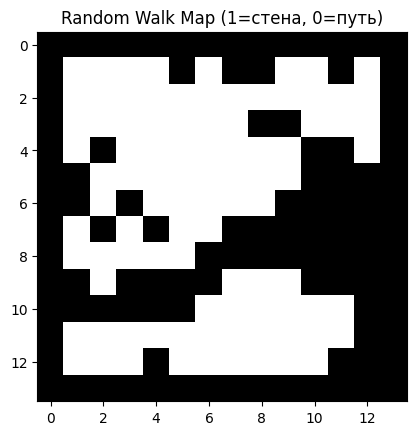

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def generate_random_walk_map(width=14, height=14, steps=500, path_prob=0.45, num_new_placements=8):
    """
    Генерирует карту с помощью случайного блуждания.

    Параметры:
        width, height: размер карты.
        steps: количество шагов блуждания.
        wall_prob: вероятность превращения клетки в стену.
    """
    # Инициализация карты (0 = путь, 1 = стена)
    grid = np.ones((width, height), dtype=int)

    # Начальная позиция "блуждателя" (в центре)
    x, y = width // 2, height // 2

    for i in range(steps):
        # Случайное направление (вверх, вниз, влево, вправо)
        dx, dy = [(0, 1), (0, -1), (1, 0), (-1, 0)][np.random.randint(4)]

        # Обновляем позицию с проверкой границ
        x = np.clip(x + dx, 1, width - 2)
        y = np.clip(y + dy, 1, height - 2)

        # С вероятностью wall_prob превращаем клетку в стену
        if np.random.rand() < path_prob:
            grid[y, x] = 0

        if i % (steps // num_new_placements) == 0 and i > 0:
          x, y = np.random.randint(1, width - 2), np.random.randint(1, height - 2)

    return grid

# Генерируем карту
map_grid = generate_random_walk_map(width=14, height=14, steps=500, path_prob=0.45, num_new_placements=8)

# Визуализация
plt.imshow(map_grid, cmap='binary', interpolation='nearest')
plt.title("Random Walk Map (1=стена, 0=путь)")
plt.show()

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 0 1 0 0 1 0 1]
 [1 0 1 1 0 0 0 0 0 1 1 0 0 1]
 [1 0 1 0 0 0 1 1 1 1 1 0 0 1]
 [1 1 1 0 0 0 1 0 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 1 0 0 1 1]
 [1 1 1 1 0 0 0 0 0 1 1 0 1 1]
 [1 0 0 0 0 1 1 1 1 0 1 1 0 1]
 [1 0 0 0 0 0 1 0 1 1 0 1 1 1]
 [1 0 0 0 0 0 0 1 0 0 0 1 1 1]
 [1 0 0 0 0 0 1 0 0 1 0 1 0 1]
 [1 0 0 0 0 0 0 1 0 0 0 0 0 1]
 [1 0 0 0 0 0 1 0 0 0 0 0 0 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


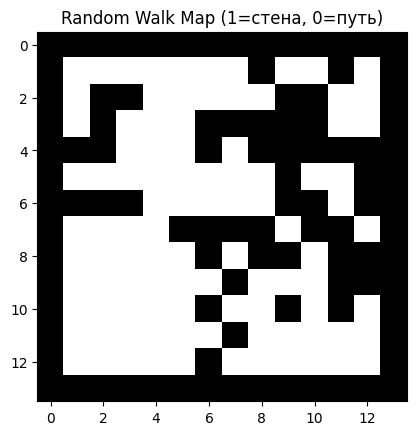

In [ ]:
print(map_grid)
plt.imshow(map_grid, cmap='binary', interpolation='nearest')
plt.title("Random Walk Map (1=стена, 0=путь)")
plt.show()

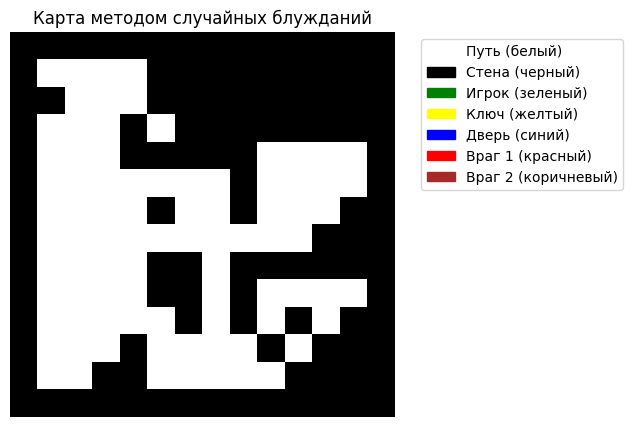

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import numpy as np

def visualize_map(map_grid, title=None):
    """Визуализация с базовыми цветами"""
    color_dict = {
        0: [255, 255, 255],  # Белый - путь
        1: [0, 0, 0],        # Черный - стена
        2: [0, 255, 0],      # Зеленый - игрок
        3: [255, 255, 0],    # Желтый - ключ
        4: [0, 0, 255],      # Синий - дверь
        5: [255, 0, 0],      # Красный - враг1
        6: [165, 42, 42]     # Коричневый - враг2
    }
    colors = [
        'white',   # 0 = путь
        'black',   # 1 = стена (должны быть черными)
        'green',   # 2 = игрок
        'yellow',  # 3 = ключ
        'blue',     # 4 = дверь
        'red',     # 5 = враг 1
        'brown',   # 6 = враг 2
    ]
    legend_labels = {
        0: 'Путь (белый)',
        1: 'Стена (черный)',
        2: 'Игрок (зеленый)',
        3: 'Ключ (желтый)',
        4: 'Дверь (синий)',
        5: 'Враг 1 (красный)',
        6: 'Враг 2 (коричневый)',
    }

    # Преобразуем в RGB изображение
    rgb_map = np.zeros((*map_grid.shape, 3), dtype=np.uint8)
    for val in np.unique(map_grid):
        rgb_map[map_grid == val] = color_dict.get(val, [128, 128, 128])


    plt.figure(figsize=(5, 5))
    patches = [Patch(color=colors[i], label=legend_labels[i]) for i in legend_labels]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.imshow(rgb_map)
    plt.axis('off')
    if title == None:
      title = "Карта методом случайных блужданий"
    plt.title(title)
    plt.show()

map_grid = generate_random_walk_map()
visualize_map(map_grid)

{'player': [(6, 2)], 'key': [(8, 5)], 'door': [(3, 1)], 'enemy1': [(8, 12), (12, 7)]}
[1, 1, 1, 2, 0]
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 1 0 0 1 0 1 1 1 1 1 1]
 [1 0 0 0 0 0 1 0 1 1 1 1 1 1]
 [1 4 0 0 0 0 0 0 0 0 1 1 1 1]
 [1 1 0 0 1 1 0 0 0 0 0 1 1 1]
 [1 1 0 0 1 1 1 0 0 0 0 1 1 1]
 [1 0 2 0 0 0 0 0 0 0 0 1 1 1]
 [1 0 0 0 1 0 0 0 0 0 0 0 0 1]
 [1 0 0 1 0 3 0 0 0 0 0 1 5 1]
 [1 0 0 1 0 0 0 0 0 0 0 1 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 0 1 0 0 0 0 0 0 0 1 1 1 1]
 [1 1 0 0 0 0 1 5 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


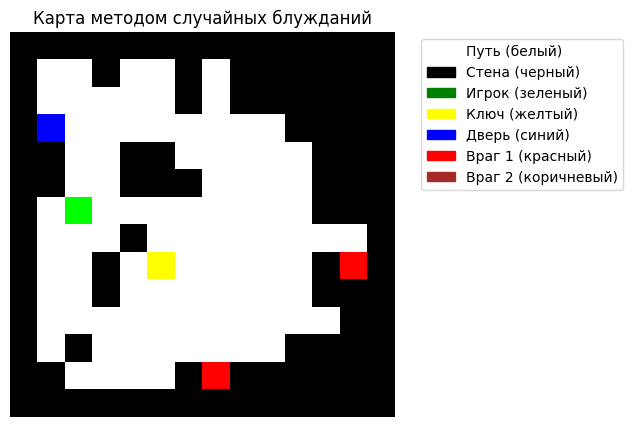

In [7]:
from scipy.spatial import distance

def find_object_placement(map_grid, object_nums, object_types=['player', 'key', 'door', 'enemy1', 'enemy2'], min_distance=3):
    """Размещает объекты с минимальным расстоянием между ними"""
    object_nums = object_nums.copy()
    walkable = np.argwhere(map_grid == 0)
    positions = {}

    attempts_left = sum(object_nums) * 3
    for i in range(len(object_types)):
        obj = object_types[i]
        while object_nums[i] > 0:
            attempts_left -= 1
            pos = walkable[np.random.randint(len(walkable))]
            pos = (int(pos[0]), int(pos[1]))

            # Проверяем расстояние до других объектов
            valid = True
            for object_positions in positions.values():
              for existing_pos in object_positions:
                if distance.euclidean(pos, existing_pos) < min_distance:
                    valid = False
                    break
              if not valid:
                break

            if valid:
              if obj in positions:
                positions[obj].append(tuple(pos))
              else:
                positions[obj] = [tuple(pos)]
              object_nums[i] -= 1

            if attempts_left <= 0:
              return None

    return positions

def place_objects(map_grid, positions, object_types=['player', 'key', 'door', 'enemy1', 'enemy2']):
  for i in range(len(object_types)):
    if object_types[i] in positions:
      for pos in positions[object_types[i]]:
        map_grid[pos[0]][pos[1]] = i + 2


map_grid = generate_random_walk_map()
object_nums = [1, 1, 1, 2, 0]
points = find_object_placement(map_grid, object_nums)
print(points)
print(object_nums)
if points:
  place_objects(map_grid, points)
print(map_grid)
visualize_map(map_grid)

In [8]:
!pip install pathfinding

In [9]:
from pathfinding.core.grid import Grid
from pathfinding.finder.a_star import AStarFinder
from pathfinding.core.diagonal_movement import DiagonalMovement
import numpy as np

def verify_paths(map_grid, points):
    """
    Проверяет существование путей между всеми точками на карте.

    :param map_grid: 2D массив карты (0 = путь, 1 = стена)
    :param points: Словарь с координатами в формате {'player': [(x1,y1)], 'key': [(x2,y2)], ...}
    :return: True если все пути существуют, иначе False
    """
    # Инвертируем карту для библиотеки pathfinding (0 = препятствие, 1 = путь)
    # map_grid: 0 - путь, 1 - стена
    pathfinding_matrix = 1 - map_grid

    # Собираем все координаты из всех категорий
    all_points = []
    for category in points.values():
        all_points.extend(category)

    # Проверяем все уникальные пары
    for i in range(len(all_points)):
        for j in range(i + 1, len(all_points)):
            x1, y1 = all_points[i]
            x2, y2 = all_points[j]

            # Проверка: координаты должны быть в проходимых клетках исходной карты
            if map_grid[x1][y1] != 0:
                # print(f"Точка находится в стене: {all_points[i]}")
                return False
            if map_grid[x2][y2] != 0:
                # print(f"Точка находится в стене: {all_points[j]}")
                return False

            # ВАЖНО: создаём новую сетку на каждую проверку
            grid = Grid(matrix=pathfinding_matrix.copy())
            start = grid.node(y1, x1)  # ВНИМАНИЕ: node(col, row)
            end = grid.node(y2, x2)

            finder = AStarFinder(diagonal_movement=DiagonalMovement.never)
            path, _ = finder.find_path(start, end, grid)

            if not path:
                # print(f"Путь не найден между {all_points[i]} и {all_points[j]}")
                return False

    return True


[[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0 1 1 0 1 1 1 0]
 [0 0 1 1 1 0 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 0 0 0 1 0]
 [0 1 1 1 1 1 1 1 0 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 0 1 1 1 0 0]
 [0 0 1 1 1 0 0 0 1 1 0 1 0 0]
 [0 1 1 1 1 1 0 0 1 0 1 0 0 0]
 [0 1 1 1 1 1 0 0 1 0 1 1 0 0]
 [0 1 1 1 1 0 0 0 1 0 1 0 0 0]
 [0 1 1 1 1 0 0 0 1 0 1 0 1 0]
 [0 1 1 1 1 0 0 0 1 1 1 1 1 0]
 [0 0 1 1 1 0 0 0 1 1 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Все пути найдены


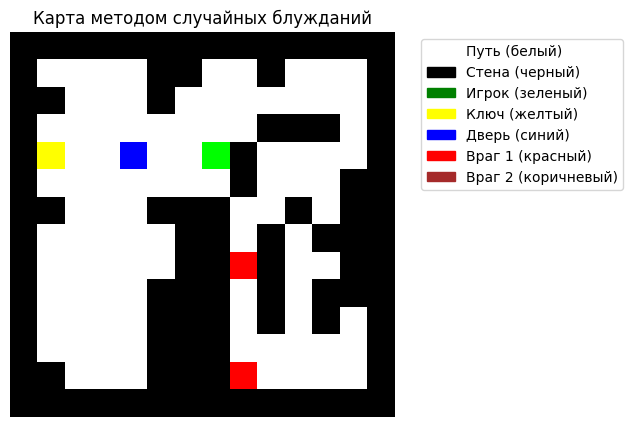

In [ ]:
map_grid = generate_random_walk_map()
object_nums = [1, 1, 1, 2, 0]
points = find_object_placement(map_grid, object_nums)
print(1 - map_grid)
if points:
  if verify_paths(map_grid, points):
    print("Все пути найдены")
  else:
    print("Путь не найден")
  place_objects(map_grid, points)
visualize_map(map_grid)

In [ ]:
dataset = {
    "object_nums": [], # вектор объектов
    "positions": [], # позиции объектов
    "maps": [], # карты
}

In [ ]:
from tqdm import tqdm

for i in tqdm(range(30)):
  map_grid = generate_random_walk_map(width=14, height=14, steps=600, path_prob=0.8, num_new_placements=8)
  object_nums = [1, 1, 0, 1, 0]
  points = find_object_placement(map_grid, object_nums)
  if points:
    if verify_paths(map_grid, points):
      place_objects(map_grid, points)
      dataset["object_nums"].append(object_nums)
      dataset["positions"].append(points)
      dataset["maps"].append(map_grid)

print()
len(dataset["object_nums"])

100%|██████████| 30/30 [00:00<00:00, 100.84it/s]

1000

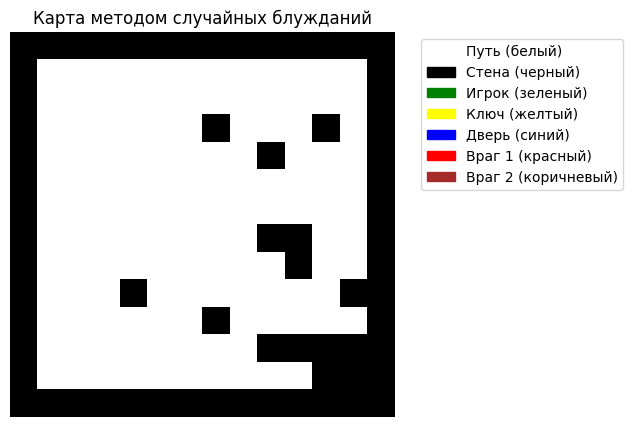

In [ ]:
import pickle
with open('game_maps_dataset.pkl', 'wb') as f:
    pickle.dump(dataset, f)

In [10]:
# Загрузка
import pickle
with open('game_maps_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

object_nums: [2, 1, 2, 2, 1]
positions: {'player': [(4, 6), (11, 6)], 'key': [(10, 2)], 'door': [(11, 11), (7, 11)], 'enemy1': [(8, 7), (2, 12)], 'enemy2': [(1, 5)]}


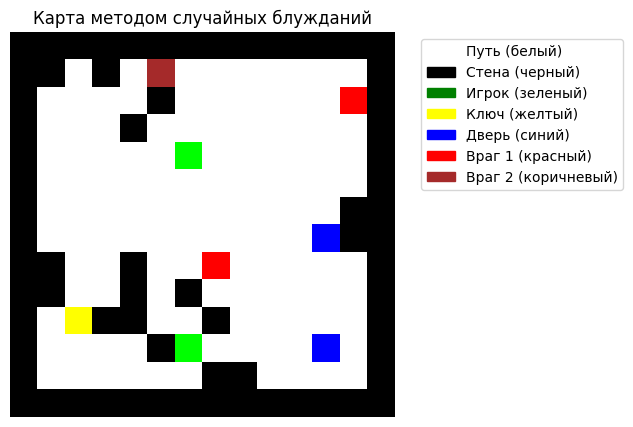

In [ ]:
dataset_index = 917
print("object_nums:", dataset["object_nums"][dataset_index])
print("positions:", dataset["positions"][dataset_index])
visualize_map(dataset["maps"][dataset_index])

# Обучение

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm

class GameMapDataset(Dataset):
    def __init__(self, maps, object_nums):
        self.maps = torch.FloatTensor(maps)
        self.object_nums = torch.FloatTensor(object_nums)
        # self.positions = positions

    def __len__(self):
        return len(self.maps)

    def __getitem__(self, idx):
        # Преобразование позиций объектов в тензор условий
        return self.object_nums[idx], self.maps[idx]

def get_dataloader(maps, objects, batch_size=32):
    dataset = GameMapDataset(maps, objects)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [15]:
def train_gan(generator, discriminator, dataloader, epochs=100, lr=0.0002):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    generator.to(device)
    discriminator.to(device)

    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    criterion = nn.BCEWithLogitsLoss()  # Изменено на BCEWithLogits

    for epoch in range(epochs):
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

        for object_nums, real_maps in progress_bar:
            batch_size = real_maps.size(0)

            # Подготовка данных
            real_maps = real_maps.to(device).unsqueeze(1)  # [B, 1, 14, 14]
            object_nums = object_nums.to(device)

            # Генерация меток
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            # ===== Обучение дискриминатора =====
            discriminator.zero_grad()

            # Реальные данные
            real_maps_expanded = real_maps.expand(-1, 7, -1, -1)  # [B, 7, 14, 14]
            d_real = discriminator(real_maps_expanded, object_nums)
            loss_real = criterion(d_real, real_labels)

            # Фейковые данные
            noise = torch.randn(batch_size, 100, device=device)
            fake_maps = generator(noise, object_nums)
            d_fake = discriminator(fake_maps.detach(), object_nums)
            loss_fake = criterion(d_fake, fake_labels)

            loss_d = (loss_real + loss_fake) * 0.5
            loss_d.backward()
            opt_d.step()

            # ===== Обучение генератора =====
            generator.zero_grad()

            d_fake = discriminator(fake_maps, object_nums)
            loss_g = criterion(d_fake, real_labels)

            # Добавляем L1 loss
            l1_loss = F.l1_loss(fake_maps, real_maps_expanded)
            total_loss = loss_g + l1_loss * 10.0

            total_loss.backward()
            opt_g.step()

            progress_bar.set_postfix({
                'D_loss': loss_d.item(),
                'G_loss': loss_g.item(),
                'L1': l1_loss.item()
            })

In [18]:
maps = dataset['maps']
objects = dataset['object_nums']

generator = Generator(
    noise_dim=100,
    embed_dim=5,
    output_channels=7,
    feature_map=64,
    picture_size=14
)

discriminator = Discriminator(
  input_channels=7,
  embed_dim=5,
  feature_map_size=64,
  picture_size=14
)

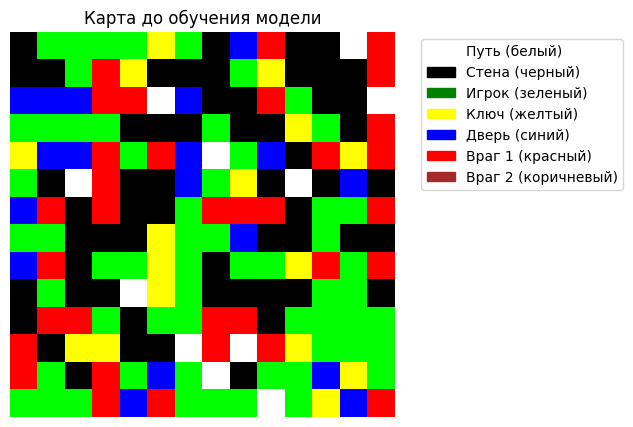

In [44]:
z = torch.randn(1, 100)
u = torch.tensor([1, 1, 1, 2, 0]).type(torch.FloatTensor).unsqueeze(0)
map = torch.argmax(generator(z, u), dim=1)[0]
visualize_map(map, title="Карта до обучения модели")

In [20]:
dataloader = get_dataloader(maps, objects, batch_size=32)
train_gan(generator, discriminator, dataloader, epochs=50)

Epoch 50/50: 100%|██████████| 32/32 [00:05<00:00,  5.67it/s, D_loss=0.527, G_loss=1.66, L1=0.531]


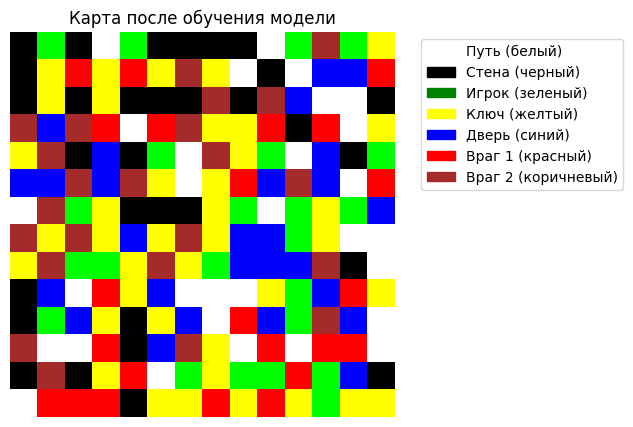

In [22]:
z = torch.randn(1, 100)
u = torch.tensor([1, 1, 1, 2, 0]).type(torch.FloatTensor).unsqueeze(0)
map = torch.argmax(generator(z, u), dim=1)[0]
visualize_map(map, title="Карта после обучения модели")